In [60]:
import re
import pandas as pd

hola


In [61]:
package_1="""CREATE OR REPLACE PACKAGE BODY Package_A AS
  FUNCTION Function_A1 (input_value IN NUMBER) RETURN NUMBER IS
  BEGIN
    RETURN input_value * 2;
  END Function_A1;

  FUNCTION Function_A2 (input_value IN NUMBER) RETURN NUMBER IS
  BEGIN
    RETURN input_value + 10;
  END Function_A2;

  FUNCTION Function_A3 (input_value IN NUMBER) RETURN NUMBER IS
  BEGIN
    RETURN input_value - 5;
  END Function_A3;

  FUNCTION Function_A4 (input_value IN NUMBER) RETURN NUMBER IS
    result_from_b NUMBER;
  BEGIN
    result_from_b := Package_B.Function_B1(input_value);
    RETURN input_value * result_from_b;
  END Function_A4;

  FUNCTION Function_A5 (input_value IN NUMBER) RETURN NUMBER IS
    result_from_b NUMBER;
  BEGIN
    result_from_b := Function_A3 (input_value);
    RETURN input_value * result_from_b;
  END Function_A5;
END Package_A;"""

In [62]:
package_2="""CREATE OR REPLACE PACKAGE BODY Package_B AS
  FUNCTION Function_B1 (input_value IN NUMBER) RETURN NUMBER IS
    result_from_a NUMBER;
  BEGIN
    result_from_a := Package_A.Function_A1(input_value);
    RETURN result_from_a + 5;
  END Function_B1;

  FUNCTION Function_B2 (input_value IN NUMBER) RETURN NUMBER IS
    result_from_a NUMBER;
  BEGIN
    result_from_a := Package_A.Function_A2(input_value);
    RETURN result_from_a * 3;
  END Function_B2;

  FUNCTION Function_B3 (input_value IN NUMBER) RETURN NUMBER IS
    result_from_a NUMBER;
  BEGIN
result_from_b := Package_A.Function_b2(input_value); result_from_a := Package_A.Function_A2(input_value);  result_from_a := Package_A.Function_A3(input_value);
    RETURN result_from_a + input_value;
  END Function_B3;
END Package_B;"""

In [63]:
package_3="""CREATE OR REPLACE PACKAGE BODY Package_C AS
  FUNCTION Function_C1 (input_value IN NUMBER) RETURN NUMBER IS
    result_from_b NUMBER;
    result_from_a NUMBER;
  BEGIN
    result_from_b := Package_B.Function_B1(input_value);
    result_from_a := Package_A.Function_A1(input_value);
    RETURN result_from_b - result_from_a;
  END Function_C1;

  FUNCTION Function_C2 (input_value IN NUMBER) RETURN NUMBER IS
    result_from_b NUMBER;
  BEGIN
    result_from_b := Package_B.Function_B2(input_value);
    result_from_a := Package_A.Function_A2(input_value);
    RETURN result_from_b / 2;
  END Function_C2;

  FUNCTION Function_C3 (input_value IN NUMBER) RETURN NUMBER IS
    result_from_b NUMBER;
    result_from_a NUMBER;
  BEGIN
    result_from_b := Package_B.Function_B3(input_value);
    result_from_a := Package_A.Function_A2(input_value);
    result_from_c := Package_A.Function_A1(input_value);
    RETURN result_from_b * result_from_a;
  END Function_C3;
END Package_C;"""

In [64]:
def name_var(var):
    import inspect
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    names = []
    names = [var_name for var_name, var_val in callers_local_vars if var_val is var and not var_name.startswith("_") ]
    Ofname = names[len(names)-1]
    return Ofname


def name_var2(xx):
    for objname, oid in globals().items():
        if oid is xx and not objname.startswith("_") :
            return objname
    return

In [65]:
def extract_routines(package_body):
    routines = []
    routine_pattern = re.compile(r"(FUNCTION|PROCEDURE)\s+(\w+)\s*\((.*?)\)\s*(RETURN\s+\w+\s*)?IS([\s\S]*?)(END\s+\2;)", re.IGNORECASE | re.DOTALL)
    # call_pattern = re.compile(r"\b(\w+)\s*\((.*?)\)", re.IGNORECASE)
    # call_pattern =re.compile(r"\b([a-zA-Z_]\w*)\s*\((.*?)\)", re.IGNORECASE)
    call_pattern = re.compile(r"\b(?!\.)([a-zA-Z_]\w*)\s*\((.*?)\)", re.IGNORECASE)
    # package_call_pattern = re.compile(r"\b(\w+)\.(\w+)\s*\((.*?)\)", re.IGNORECASE) # To capture package.routine calls
    package_call_pattern =  re.compile(r"\b(\w+)\.(\w+)\s*\((.*?)\)", re.IGNORECASE) # To capture package.routine calls


    matches = routine_pattern.finditer(package_body)
    for match in matches:
        routine_type = match.group(1).upper()
        routine_name = match.group(2)
        parameters_str = match.group(3).strip()
        return_type = match.group(4).strip() if match.group(4) else None
        body = match.group(5).strip()

        parameters = []
        if parameters_str:
            for param in parameters_str.split(','):
                param = param.strip()
                if param:
                    parts = param.split()
                    param_name = parts[0]
                    param_mode = None
                    param_datatype = None
                    if len(parts) >= 3 and parts[1].upper() in ('IN', 'OUT', 'IN OUT'):
                        param_mode = parts[1].upper()
                        param_datatype = ' '.join(parts[2:])
                    elif len(parts) >= 2:
                        param_datatype = ' '.join(parts[1:])
                    parameters.append({'name': param_name, 'mode': param_mode, 'datatype': param_datatype})

        local_called_routines = set()
        # Find local calls
        call_matches = call_pattern.finditer(body)
        for call_match in call_matches:
            called_name = call_match.group(1)
            if not called_name.upper() in ( 'AND', 'MOD','PUT_LINE', 'DBMS_OUTPUT','VARCHAR2','IF', 'THEN', 'ELSE', 'ELSIF', 'LOOP', 'FOR', 'WHILE', 'BEGIN', 'END', 'NULL', 'RETURN', 'RAISE', 'COMMIT', 'ROLLBACK', 'DECLARE', 'TYPE', 'CURSOR', 'RECORD'):
                local_called_routines.add(called_name)

        ext_called_routines = set()
        # Find calls to other packages (package.routine)
        package_call_matches = package_call_pattern.finditer(body)
        for pkg_call_match in package_call_matches:
            called_package = pkg_call_match.group(1)
            called_routine = pkg_call_match.group(2)
            if not called_package.upper() in ( 'DBMS_OUTPUT'):
               ext_called_routines.add(f"{called_package}.{called_routine}")

        routines.append({'package_Name': name_var2(package_body),'type': routine_type, 'name': routine_name, 'parameters': parameters,
                         'return_type': return_type, 'All_calls': list(local_called_routines), 'Ext_calls': list(ext_called_routines)})
    return routines

In [66]:
pd.DataFrame(extract_routines(package_1))

,package_Name,type,name,parameters,return_type,All_calls,Ext_calls
0,package_1,FUNCTION,Function_A1,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,[],[]
1,package_1,FUNCTION,Function_A2,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,[],[]
2,package_1,FUNCTION,Function_A3,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,[],[]
3,package_1,FUNCTION,Function_A4,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,[Function_B1],[Package_B.Function_B1]
4,package_1,FUNCTION,Function_A5,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,[Function_A3],[]


In [67]:
pd.DataFrame(extract_routines(package_2))

,package_Name,type,name,parameters,return_type,All_calls,Ext_calls
0,package_2,FUNCTION,Function_B1,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,[Function_A1],[Package_A.Function_A1]
1,package_2,FUNCTION,Function_B2,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,[Function_A2],[Package_A.Function_A2]
2,package_2,FUNCTION,Function_B3,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,"[Function_b2, Function_A3, Function_A2]","[Package_A.Function_b2, Package_A.Function_A2,..."


In [68]:
pd.DataFrame(extract_routines(package_3))

,package_Name,type,name,parameters,return_type,All_calls,Ext_calls
0,package_3,FUNCTION,Function_C1,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,"[Function_B1, Function_A1]","[Package_B.Function_B1, Package_A.Function_A1]"
1,package_3,FUNCTION,Function_C2,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,"[Function_B2, Function_A2]","[Package_B.Function_B2, Package_A.Function_A2]"
2,package_3,FUNCTION,Function_C3,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,"[Function_B3, Function_A1, Function_A2]","[Package_A.Function_A1, Package_A.Function_A2,..."


In [69]:
tableandfunctions=pd.DataFrame(extract_routines(package_1))

In [70]:
tableandfunctions=pd.concat([pd.DataFrame(extract_routines(package_1)), pd.DataFrame(extract_routines(package_2)), pd.DataFrame(extract_routines(package_3))])

In [71]:
tableandfunctions

,package_Name,type,name,parameters,return_type,All_calls,Ext_calls
0,package_1,FUNCTION,Function_A1,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,[],[]
1,package_1,FUNCTION,Function_A2,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,[],[]
2,package_1,FUNCTION,Function_A3,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,[],[]
3,package_1,FUNCTION,Function_A4,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,[Function_B1],[Package_B.Function_B1]
4,package_1,FUNCTION,Function_A5,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,[Function_A3],[]
0,package_2,FUNCTION,Function_B1,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,[Function_A1],[Package_A.Function_A1]
1,package_2,FUNCTION,Function_B2,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,[Function_A2],[Package_A.Function_A2]
2,package_2,FUNCTION,Function_B3,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,"[Function_b2, Function_A3, Function_A2]","[Package_A.Function_b2, Package_A.Function_A2,..."
0,package_3,FUNCTION,Function_C1,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,"[Function_B1, Function_A1]","[Package_B.Function_B1, Package_A.Function_A1]"
1,package_3,FUNCTION,Function_C2,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,"[Function_B2, Function_A2]","[Package_B.Function_B2, Package_A.Function_A2]"


In [72]:
import pandas as pd

def expandir_lista_columna(df, columna_lista):
    """
    Expande una columna de lista en un DataFrame a nuevas filas.

    Args:
        df (pd.DataFrame): El DataFrame de entrada.
        columna_lista (str): El nombre de la columna que contiene las listas.

    Returns:
        pd.DataFrame: Un nuevo DataFrame con las listas expandidas.
    """
    return df.explode(columna_lista)

In [121]:
tableandfunctions

exploded_df = expandir_lista_columna(tableandfunctions.copy(), 'All_calls')
exploded_df.reset_index(inplace=True)
exploded_df.drop(['index'], axis='columns', inplace=True)

exploded_df.reset_index(inplace=False)

,index,package_Name,type,name,parameters,return_type,All_calls,Ext_calls
0,0,package_1,FUNCTION,Function_A1,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,NaN,[]
1,1,package_1,FUNCTION,Function_A2,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,NaN,[]
2,2,package_1,FUNCTION,Function_A3,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,NaN,[]
3,3,package_1,FUNCTION,Function_A4,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,Function_B1,[Package_B.Function_B1]
4,4,package_1,FUNCTION,Function_A5,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,Function_A3,[]
5,5,package_2,FUNCTION,Function_B1,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,Function_A1,[Package_A.Function_A1]
6,6,package_2,FUNCTION,Function_B2,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,Function_A2,[Package_A.Function_A2]
7,7,package_2,FUNCTION,Function_B3,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,Function_b2,"[Package_A.Function_b2, Package_A.Function_A2,..."
8,8,package_2,FUNCTION,Function_B3,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,Function_A3,"[Package_A.Function_b2, Package_A.Function_A2,..."
9,9,package_2,FUNCTION,Function_B3,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,Function_A2,"[Package_A.Function_b2, Package_A.Function_A2,..."


In [122]:
if __name__ == "__main__":
    df=exploded_df

    id_column = 'name'
    parent_column = 'All_calls'
    name_column = 'name'

    hierarchy_nodes = build_hierarchy_from_df(df, id_column, parent_column, name_column)

    # Find the root nodes (those with parent as None)
    root_nodes = [node for node in hierarchy_nodes.values() if node.parent is None]

    print("Tree Hierarchy from DataFrame:")
    print_hierarchy(root_nodes)

Tree Hierarchy from DataFrame:
├── Function_A1
│   ├── Function_B1
│   │   ├── Function_A4
│   │   └── Function_C1
│   ├── Function_C1
│   └── Function_C3
├── Function_A2
│   ├── Function_B2
│   │   └── Function_C2
│   ├── Function_B3
│   │   └── Function_C3
│   ├── Function_C2
│   └── Function_C3
└── Function_A3
    ├── Function_A5
    └── Function_B3
        └── Function_C3


In [123]:
    # Accessing specific nodes:

    node_7 = hierarchy_nodes.get('Function_B2')
    # if node_7:
    print(f"Parent of {node_7.name}: {node_7.children}")

Parent of Function_B2: [Node(id=Function_C2, name='Function_C2')]


In [77]:
root_nodes

[Node(id=Function_A1, name='Function_A1'),
 Node(id=Function_A2, name='Function_A2'),
 Node(id=Function_A3, name='Function_A3')]

In [78]:
# tableandfunctions

In [124]:

tableandfunctions

exploded_df = expandir_lista_columna(tableandfunctions.copy(), 'All_calls')
exploded_df.reset_index(inplace=True)
exploded_df.drop(['index'], axis='columns', inplace=True)

exploded_df

,package_Name,type,name,parameters,return_type,All_calls,Ext_calls
0,package_1,FUNCTION,Function_A1,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,NaN,[]
1,package_1,FUNCTION,Function_A2,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,NaN,[]
2,package_1,FUNCTION,Function_A3,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,NaN,[]
3,package_1,FUNCTION,Function_A4,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,Function_B1,[Package_B.Function_B1]
4,package_1,FUNCTION,Function_A5,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,Function_A3,[]
5,package_2,FUNCTION,Function_B1,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,Function_A1,[Package_A.Function_A1]
6,package_2,FUNCTION,Function_B2,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,Function_A2,[Package_A.Function_A2]
7,package_2,FUNCTION,Function_B3,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,Function_b2,"[Package_A.Function_b2, Package_A.Function_A2,..."
8,package_2,FUNCTION,Function_B3,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,Function_A3,"[Package_A.Function_b2, Package_A.Function_A2,..."
9,package_2,FUNCTION,Function_B3,"[{'name': 'input_value', 'mode': 'IN', 'dataty...",RETURN NUMBER,Function_A2,"[Package_A.Function_b2, Package_A.Function_A2,..."


In [125]:
exploded_df[['name', 'All_calls']].to_dict(orient='records')

[{'name': 'Function_A1', 'All_calls': nan},
 {'name': 'Function_A2', 'All_calls': nan},
 {'name': 'Function_A3', 'All_calls': nan},
 {'name': 'Function_A4', 'All_calls': 'Function_B1'},
 {'name': 'Function_A5', 'All_calls': 'Function_A3'},
 {'name': 'Function_B1', 'All_calls': 'Function_A1'},
 {'name': 'Function_B2', 'All_calls': 'Function_A2'},
 {'name': 'Function_B3', 'All_calls': 'Function_b2'},
 {'name': 'Function_B3', 'All_calls': 'Function_A3'},
 {'name': 'Function_B3', 'All_calls': 'Function_A2'},
 {'name': 'Function_C1', 'All_calls': 'Function_B1'},
 {'name': 'Function_C1', 'All_calls': 'Function_A1'},
 {'name': 'Function_C2', 'All_calls': 'Function_B2'},
 {'name': 'Function_C2', 'All_calls': 'Function_A2'},
 {'name': 'Function_C3', 'All_calls': 'Function_B3'},
 {'name': 'Function_C3', 'All_calls': 'Function_A1'},
 {'name': 'Function_C3', 'All_calls': 'Function_A2'}]

In [126]:
def generate_graphnet(df , functionname, colid, colrelated):
    import pandas as pd
    import networkx as nx
    import matplotlib.pyplot as plt
    import numpy as np
    import networkx as nx
    from networkx import Graph
    functionname=functionname
    df = df

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges from the entire dataset
    for index, row in df.iterrows():
        caller = row[colid]
        callee = row[colrelated]
        if pd.notna(callee):
            if isinstance(callee, str):
                G.add_edge(caller, callee)
            elif isinstance(callee, list):
                for c in callee:
                    G.add_edge(caller, c)
        else:
            G.add_node(caller) # Ensure nodes with no calls are also added
# Identify nodes related to 'Function_A1'
    related_nodes = set()
    related_nodes.add(functionname)

    # Find direct neighbors (parents and children) of 'Function_A1'
    for source, target in G.edges():
        if source == functionname:
            related_nodes.add(target)
        elif target == functionname:
            related_nodes.add(source)



    # Choose the direction to explore
    print("Choose the direction to explore:")
    print("1: Outgoing calls (what Function_A1 calls)")
    print("2: Incoming calls (what calls Function_A1)")
    print("3: Both incoming and outgoing calls")
    direction_choice = input("Enter your choice (1, 2, or 3): ")

    related_nodes = set()
    related_nodes.add(functionname)

    if direction_choice == '1':
        # Explore outgoing calls
        for neighbor in G.successors(functionname):
            related_nodes.add(neighbor)
        subgraph = G.subgraph(related_nodes)
        title = f"Outgoing Calls from {functionname}"
    elif direction_choice == '2':
        # Explore incoming calls
        for neighbor in G.predecessors(functionname):
            related_nodes.add(neighbor)
        subgraph = G.subgraph(related_nodes)
        title = f"Incoming Calls to {functionname}"
    elif direction_choice == '3':
        # Explore both incoming and outgoing calls
        for neighbor in G.successors(functionname):
            related_nodes.add(neighbor)
        for neighbor in G.predecessors(functionname):
            related_nodes.add(neighbor)
        subgraph = G.subgraph(related_nodes)
        title = f"Incoming and Outgoing Calls of {functionname}"
    else:
        print("Invalid choice. Showing the immediate neighbors (both directions).")
        for neighbor in G.successors(functionname):
            related_nodes.add(neighbor)
        for neighbor in G.predecessors(functionname):
            related_nodes.add(neighbor)
        subgraph = G.subgraph(related_nodes)
        title = f"Immediate Neighbors of {functionname}"

        # Create a subgraph containing only the related nodes and their edges
    subgraph = G.subgraph(related_nodes)
        # Visualize the subgraph
    pos = nx.spring_layout(subgraph)

        # Customize node colors: Highlight Function_A1
    node_colors = ['lightblue' if node != functionname else 'red' for node in subgraph.nodes()]

    nx.draw(subgraph, pos, with_labels=True, node_size=3000, node_color=node_colors,
                font_size=10, font_weight='bold', arrowsize=20)
    plt.title("Graph Focused on " + functionname)
    return plt.show()

Choose the direction to explore:
1: Outgoing calls (what Function_A1 calls)
2: Incoming calls (what calls Function_A1)
3: Both incoming and outgoing calls
Enter your choice (1, 2, or 3): 3


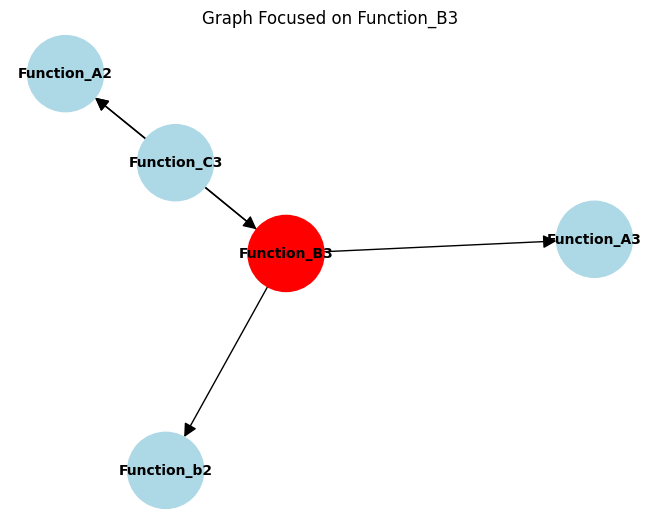

In [128]:
generate_graphnet(exploded_df, 'Function_B3', 'name', 'All_calls')

In [119]:
def all_funct_graph (df ,  colid, colrelated):
    import pandas as pd
    import networkx as nx
    import matplotlib.pyplot as plt
    import numpy as np

    # Create an empty directed graph
    G = nx.DiGraph()

    # Add nodes from the 'name' column
    nodes = df[colid].unique()
    G.add_nodes_from(nodes)

    # Add edges based on the 'All_calls' column
    for index, row in df.iterrows():
        caller = row[colid]
        callee = row[colrelated]
        if pd.notna(callee):
            # Handle cases where a function calls multiple other functions (due to duplicates)
            if isinstance(callee, str):
                G.add_edge(caller, callee)
            elif isinstance(callee, list):
                for c in callee:
                    G.add_edge(caller, c)

    # Visualize the graph
    pos = nx.spring_layout(G)  # You can try other layouts like nx.circular_layout(G)

    nx.draw(G, pos, with_labels=True, node_size=100, node_color='lightblue',
            font_size=10, font_weight='bold', arrowsize=10)
    plt.title("Function Call Network")
    return plt.show()

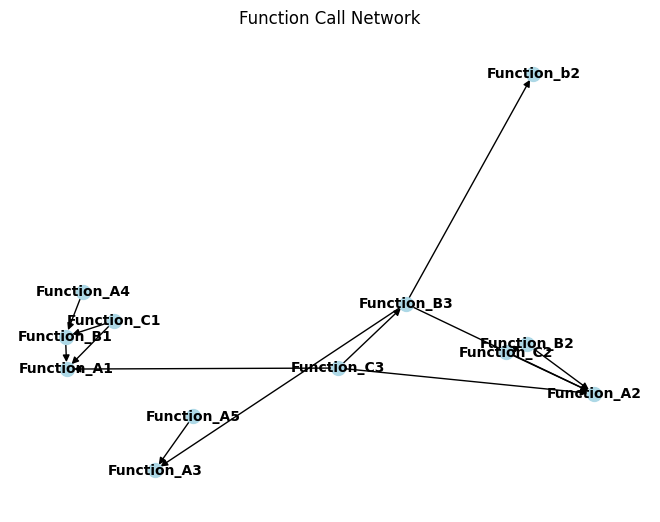

In [120]:
all_funct_graph(exploded_df,'name', 'All_calls')